In [108]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); 
using ForwardDiff
using Test
using RobotZoo
using RobotDynamics
using LinearAlgebra
using StaticArrays
using SparseArrays
using Printf
using MeshCat
using Plots
using FiniteDiff

include("quadratic_cost.jl")
include("../test/nlp_test.jl")
include("cartpole.jl")

  Activating environment at `~/Classes/16745_OptimalControl/hw3_solutions/Project.toml`


get_control (generic function with 1 method)

# Q1: Sequential Quadratic Programming (SQP) (50 pts)
In this problem you'll solve the canonical cartpole swing-up problem using the classic direct collocation algorithm with Hermite-Simpson integration. Note that the implementation we'll be using this homework problem is slightly different than the derivation we saw in lecture. Using the methods for evaluating your direct collocation problem, you'll finish the implementation of a simple sequential-quadratic programming (SQP) solver to solve the nonlinear problem. While coding up a complete SQP solver is very challenging, we'll simplify it by only considering problems of the form:

$$\begin{aligned} &\text{minimize}_z && \frac{1}{2} z^T Q z + q^T z \\
&\text{subject to} && c(z) = 0 \end{aligned} $$

I.e. we'll only have you worry about equality constraints. Your overall algorithm should run something like this:
1. Initialization
2. Build the QP for the current step by taking Taylor series approximations of the cost and constraints
3. Solve the QP to get search directions for you primal and dual variables
4. Use a line search (or other globalization strategy) to find a good step
5. If termination conditions are satisfied, exit; otherwise, go to 2

## The Problem
You likely have already seen the cartpole swing-up problem previously. As shown in the picture below, the system is comprised of a pendulum attached to a cart, where forces can only be applied to the cart. The goal is to balance the pendulum above the cart. The system dynamics can be written as:

$$ x = \begin{bmatrix} y \\ \theta \\ v \\ \omega \end{bmatrix}, \quad \dot{x} = \begin{bmatrix} \dot{q} \\ \ddot{q} \end{bmatrix}, \quad
q = \begin{bmatrix} y \\ \theta \end{bmatrix}, \quad
\ddot{q} = -H^{-1} (C \dot{q} + G - B u)$$

where 
$$ H = \begin{bmatrix} m_c + m_p & m_p l \cos{\theta} \\
m_p l \cos{\theta} & m_p l^2 \end{bmatrix}, \;
C = \begin{bmatrix} 0 & -m_p \omega l \sin{\theta} \\ 0 & 0 \end{bmatrix}, \;
G = \begin{bmatrix} 0 \\ m_p g l \sin{\theta} \end{bmatrix}, \;
B = \begin{bmatrix} 1 \\ 0 \end{bmatrix} $$

with the following parameters:
* $m_p$: mass of the pole
* $m_c$: mass of the cart
* $g$: gravity
* $l$: length of the rod

In [2]:
Base.@kwdef struct CartpoleProblem{T}
    model::RobotZoo.Cartpole{T} = RobotZoo.Cartpole()
    n::Int = 4                               # num states
    m::Int = 1                               # num controls
    N::Int = 101                             # horizon
    tf::T = 2.0                              # final time (sec)
    x0::SVector{4,T} = @SVector zeros(4)     # initial state
    xf::SVector{4,T} = SA[0,pi,0,0.]         # goal state
    Q::Diagonal{T, SVector{4,T}} = Diagonal(@SVector fill(1e-2, 4))
    R::Diagonal{T, SVector{1,T}} = Diagonal(@SVector fill(5e-0, 1))
    Qf::Diagonal{T, SVector{4,T}} = Diagonal(@SVector fill(1e1, 4))
end

function get_objective(prob::CartpoleProblem)
    costfun = LQRCost(prob.Q, prob.R, prob.xf)
    costterm = LQRCost(prob.Qf, prob.R, prob.xf)
    obj = push!(fill(costfun, prob.N-1), costterm)
    return obj
end

function get_initial_trajectory(prob::CartpoleProblem)
    tf = prob.tf
    x0 = prob.x0
    xf = prob.xf
    times = range(0,tf,length=prob.N)
    X = map(times) do t
        alpha = t / tf
        SA[
            sin(alpha * 2pi)*0,
            -pi * alpha,
            cos(alpha * 2pi)*0,
            -alpha*0
        ]
    end
    X[end] = xf
    # X = [x0 + (xf - x0)*t for t in range(0,1, length=T)]
    U = [@SVector zeros(prob.m) for k = 1:prob.N];
    return X, U
end

get_initial_trajectory (generic function with 1 method)

In [3]:
prob = CartpoleProblem();

In [4]:
let model = prob.model
    global vis = Visualizer()
    set_mesh!(vis, model)
    render(vis)
end

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/brian/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [5]:
let X = get_initial_trajectory(prob)[1]
    visualize!(vis, prob.model, prob.tf, X)
end

## Part (a): Evaluate the NLP
Before we put together our SQP method, let's write some convenient methods for evaluating the information we'll need from the NLP. We've given you a struct `NLP` below that contains all the information you'll need to evaluate things like the cost function, constraints, and their derivatives.

In [13]:
"""
    NLP{n,m,L,Q}

Represents a (N)on(L)inear (P)rogram of a trajectory optimization problem,
with a dynamics model of type `L`, a quadratic cost function, horizon `T`, 
and initial and final state `x0`, `xf`.

The kth state and control can be extracted from the concatenated state vector `Z` using
`Z[nlp.xinds[k]]`, and `Z[nlp.uinds[k]]`.

# Constructor
    NLP(model, obj, tf, T, x0, xf, [integration])

# Basic Methods
    Base.size(nlp)    # returns (n,m,T)
    num_ineq(nlp)     # number of inequality constraints
    num_eq(nlp)       # number of equality constraints
    num_primals(nlp)  # number of primal variables
    num_duals(nlp)    # total number of dual variables
    packZ(nlp, X, U)  # Stacks state `X` and controls `U` into one vector `Z`

# Evaluating the NLP
The NLP supports the following API for evaluating various pieces of the NLP:

    eval_f(nlp, Z)         # evaluate the objective
    grad_f!(nlp, grad, Z)  # gradient of the objective
    hess_f!(nlp, hess, Z)  # Hessian of the objective
    eval_c!(nlp, c, Z)     # evaluate the constraints
    jac_c!(nlp, c, Z)      # constraint Jacobian
"""
struct NLP{n,m,L}
    model::L                                 # dynamics model
    obj::Vector{QuadraticCost{n,m,Float64}}  # objective function
    N::Int                                   # number of knot points
    tf::Float64                              # total time (sec)
    x0::MVector{n,Float64}                   # initial condition
    xf::MVector{n,Float64}                   # final condition
    xinds::Vector{SVector{n,Int}}            # Z[xinds[k]] gives states for time step k
    uinds::Vector{SVector{m,Int}}            # Z[uinds[k]] gives controls for time step k
    times::Vector{Float64}                   # vector of times
    f::Vector{SVector{4,Float64}}
    A::Vector{SMatrix{4,4,Float64,16}}
    B::Vector{SMatrix{4,1,Float64,4}}
    xm::Vector{SVector{4,Float64}}
    um::Vector{SVector{1,Float64}}
    fm::Vector{SVector{4,Float64}}
    Am::Matrix{SMatrix{4,4,Float64,16}}
    Bm::Matrix{SMatrix{4,1,Float64,4}}
    function NLP(prob::CartpoleProblem)
        n,m,N = prob.n, prob.m, prob.N
        xinds = [SVector{n}((k-1)*(n+m) .+ (1:n)) for k = 1:N]
        uinds = [SVector{m}((k-1)*(n+m) .+ (n+1:n+m)) for k = 1:N]
        times = collect(range(0, prob.tf, length=N))
        obj = get_objective(prob)
        f = [@SVector zeros(n) for k = 1:N]
        A = [@SMatrix zeros(n,n) for k = 1:N]
        B = [@SMatrix zeros(n,m) for k = 1:N]
        xm = deepcopy(f)
        um = [@SVector zeros(m) for k = 1:N]
        fm = deepcopy(f)
        Am = [@SMatrix zeros(n,n) for k = 1:N, i = 1:3]
        Bm = [@SMatrix zeros(n,m) for k = 1:N, i = 1:3]
        new{n,m,typeof(prob.model)}(
            prob.model, obj,
            N, prob.tf, prob.x0, prob.xf, xinds, uinds, times,
            f,A,B,xm,um,fm,Am,Bm
        )
    end
end
Base.size(nlp::NLP{n,m}) where {n,m} = (n,m,nlp.N)
num_primals(nlp::NLP{n,m}) where {n,m} = (n + m)*nlp.N
num_duals(nlp::NLP) = num_eq(nlp) + num_ineq(nlp)
num_eq(nlp::NLP{n,m}) where {n,m} = n*nlp.N + n
num_ineq(nlp::NLP) = 0

"""
    packZ(nlp, X, U)

Take a vector state vectors `X` and controls `U` and stack them into a single vector Z.
"""
function packZ(nlp, X, U)
    Z = zeros(num_primals(nlp))
    for k = 1:nlp.N
        Z[nlp.xinds[k]] = X[k]
        Z[nlp.uinds[k]] = U[k]
    end
    return Z
end

"""
    unpackZ(nlp, Z)

Take a vector of all the states and controls and return a vector of state vectors `X` and
controls `U`.
"""
function unpackZ(nlp, Z)
    X = [Z[xi] for xi in nlp.xinds]
    U = [Z[ui] for ui in nlp.uinds]
    return X, U
end

unpackZ

### Useful Examples
You may find the following code snippets helpful as you complete the methods for the NLP.

In [14]:
let
    # Create NLP
    nlp = NLP(prob)

    # Create a vector of all states and controls
    X,U = get_initial_trajectory(prob)
    Z = packZ(nlp, X, U)

    # Unpack into states and vectors
    X2, U2 = unpackZ(nlp, Z)

    # Evaluate the cost
    cost(nlp.obj, X, U)

    # Get kth state, control
    k = 10
    x = Z[nlp.xinds[k]]
    u = Z[nlp.uinds[k]]

    # Dynamics
    t = nlp.times[k]
    dt = nlp.times[k+1] - nlp.times[k]
    dynamics(nlp.model, x, u, t)

    # Dynamics Jacobian
    A,B = dynamics_jacobians(nlp.model, x, u, t);
end;

## Evaluate Dynamics

In [64]:
function evaluate_dynamics!(nlp::NLP, Z)
    ix,iu = nlp.xinds, nlp.uinds
    for k = 1:nlp.N
        t = nlp.times[k]
        x,u = Z[ix[k]], Z[iu[k]]
        nlp.f[k] = dynamics(nlp.model, x, u, t)
    end
end

function evaluate_dynamics_jacobians!(nlp::NLP, Z)
    ix,iu = nlp.xinds, nlp.uinds
    for k = 1:nlp.N
        t = nlp.times[k]
        x,u = Z[ix[k]], Z[iu[k]]
        nlp.A[k], nlp.B[k] = dynamics_jacobians(nlp.model, x, u, t)
    end
end

function evaluate_midpoints!(nlp::NLP, Z)
    ix,iu = nlp.xinds, nlp.uinds
    for k = 1:nlp.N-1
        # Extract data
        h = nlp.times[k+1] - nlp.times[k]
        t = nlp.times[k]
        x1,x2 = Z[ix[k]], Z[ix[k+1]]
        u1,u2 = Z[iu[k]], Z[iu[k+1]]
        f1 = nlp.f[k]
        f2 = nlp.f[k+1]
        A1,A2 = nlp.A[k], nlp.A[k+1]
        B1,B2 = nlp.B[k], nlp.B[k+1]
        
        # Calculate midpoint
        xm = (x1 + x2) / 2 + h/8 * (f1 - f2)
        um = (u1 + u2) / 2
        
        # Evaluate dynamics at the midpoint
        fm = dynamics(nlp.model, xm, um, t + h/2)
        
        # Cache the results
        nlp.fm[k] = fm
        nlp.xm[k] = xm
        nlp.um[k] = um
    end    
end

function evaluate_midpoint_jacobians!(nlp::NLP, Z)
    ix,iu = nlp.xinds, nlp.uinds
    for k = 1:nlp.N-1
        # Extract data
        h = nlp.times[k+1] - nlp.times[k]
        t = nlp.times[k]
        x1,x2 = Z[ix[k]], Z[ix[k+1]]
        u1,u2 = Z[iu[k]], Z[iu[k+1]]
        f1 = nlp.f[k]
        f2 = nlp.f[k+1]
        A1,A2 = nlp.A[k], nlp.A[k+1]
        B1,B2 = nlp.B[k], nlp.B[k+1]
        
        # Get midpoints
        xm, um = nlp.xm[k], nlp.um[k]

        # Evaluate dynamics at the midpoint
        fm = dynamics(nlp.model, xm, um, t + h/2)
        
        # Dynamics Jacobians at midpoint
        Am,Bm = dynamics_jacobians(nlp.model, xm, um, t + h/2)
        
        # Derivatives of xm, um,
        dxmx1 = (I/2 + h/8 * A1)    # (n,n)
        dxmu1 = h/8 * B1            # (n,m)
        dxmx2 = (I/2 - h/8 * A2)    # (n,n)
        dxmu2 = -h/8 * B2           # (n,m)
        dumu1 = I/2                 # (m,m)
        dumu2 = I/2                 # (m,m)
        
        # Cache the results
        nlp.fm[k] = fm
        nlp.xm[k] = xm
        nlp.um[k] = um
        nlp.Am[k,1], nlp.Am[k,2], nlp.Am[k,3] = Am, dxmx1, dxmx2
        nlp.Bm[k,1], nlp.Bm[k,2], nlp.Bm[k,3] = Bm, dxmu1, dxmu2
    end    
end

evaluate_midpoint_jacobians! (generic function with 1 method)

In [65]:
let nlp = NLP(prob)
    Z = packZ(nlp, get_initial_trajectory(prob)...)
    evaluate_dynamics!(nlp, Z)
    evaluate_dynamics_jacobians!(nlp, Z)
    evaluate_midpoints!(nlp, Z)
    evaluate_midpoint_jacobians!(nlp, Z)
end

### Objective
Complete the following methods to evaluate the objective and its derivatives.

In [104]:
# TASK: Finish the following methods
#       eval_f
#       grad_f!
#       hess_f!

"""
    eval_f(nlp, Z)

Evaluate the objective, returning a scalar.
"""
function eval_f(nlp::NLP, Z)
    # TASK: compute the objective value (cost)
    J = 0.0
    
    # SOLUTION
    ix,iu = nlp.xinds, nlp.uinds
    evaluate_dynamics!(nlp, Z)
    evaluate_midpoints!(nlp, Z)
    J1 = 0.0
    let k = 1
        x1,u1 = Z[ix[k]], Z[iu[k]]
        J1 = stagecost(nlp.obj[k], x1, u1)
    end
    for k = 1:nlp.N-1
        t = nlp.times[k]
        h = nlp.times[k+1] - nlp.times[k]
        x2,u2 = Z[ix[k+1]], Z[iu[k+1]]
        J2 = stagecost(nlp.obj[k+1], x2, u2)
        
        xm = nlp.xm[k]
        um = nlp.um[k]
        Jm = stagecost(nlp.obj[k], xm, um)
        J += h/6 * (J1 + 4Jm + J2)
        
        J1 = J2
        x1,u1 = x2,u2
    end
    return J
end

"""
    grad_f!(nlp, grad, Z)

Evaluate the gradient of the objective at `Z`, storing the result in `grad`.
"""
function grad_f!(nlp::NLP{n,m}, grad, Z) where {n,m}
    ix,iu = nlp.xinds, nlp.uinds
    obj = nlp.obj
    evaluate_dynamics!(nlp, Z)
    evaluate_midpoints!(nlp, Z)
    evaluate_dynamics_jacobians!(nlp, Z)
    evaluate_midpoint_jacobians!(nlp, Z)

    grad .= 0
    
    for k = 1:nlp.N-1
        x1,x2 = Z[ix[k]], Z[ix[k+1]]
        u1,u2 = Z[iu[k]], Z[iu[k+1]]
        xm = nlp.xm[k]
        um = nlp.um[k]
        t = nlp.times[k]
        h = nlp.times[k+1] - nlp.times[k]
        
        # TASK: Compute the cost gradient
#         grad[ix[k]] .= 0
#         grad[iu[k]] .= 0
        
        # SOLUTION
        dxmx1, dxmx2 = nlp.Am[k,2], nlp.Am[k,3]
        dxmu1, dxmu2 = nlp.Bm[k,2], nlp.Bm[k,3]
        
        dx1 = obj[k].Q*x1 + obj[k].q
        dx2 = obj[k+1].Q*x2 + obj[k+1].q
        du1 = obj[k].R*u1 + obj[k].r
        du2 = obj[k+1].R*u2 + obj[k+1].r
        dxm = obj[k].Q*xm + obj[k].q
        dum = obj[k].R*um + obj[k].r
        
        grad[ix[k]] += h/6 * (dx1 + 4dxmx1'dxm)
        grad[ix[k+1]] += h/6 * (dx2 + 4dxmx2'dxm)
        grad[iu[k]] += h/6 * (du1 + 4dxmu1'dxm + dum/2)
        grad[iu[k+1]] += h/6 * (du2 + 4dxmu2'dxm + dum/2)
    end
    return nothing
end

"""
    hess_f!(nlp, hess, Z)

Evaluate the Hessian of the objective at `Z`, storing the result in `hess`.
Should work with `hess` sparse.
"""
function hess_f!(nlp::NLP{n,m}, hess, Z) where {n,m}
    # TASK: Compute the objective hessian
    ix,iu = nlp.xinds, nlp.uinds
    obj = nlp.obj
    hess .= 0
    for k = 1:nlp.N-1
        Am1,Am2 = nlp.Am[k,1], nlp.Am[k,2]
        Bm1,Bm2 = nlp.Bm[k,1], nlp.Bm[k,2]
#         dx1x1 = obj[k].Q + 4*Am1'obj[k]*Am1
#         du1u1 = obj[k].R + 4*Bm1'obj
    end
end

hess_f!

In [112]:
function eval_f2(nlp, Z)
    N = nlp.N
    X,U = unpackZ(nlp, Z)
    function xmid(k)
        h = nlp.times[k+1] - nlp.times[k]
        f1 = dynamics(nlp.model, X[k], U[k], nlp.times[k])
        f2 = dynamics(nlp.model, X[k+1], U[k+1], nlp.times[k+1])
        (X[k] + X[k+1]) / 2 + h/8 * (f1 - f2)
    end
    umid(k) = (U[k] + U[k+1]) / 2
    Xm = xmid.(1:N-1)
    Um = umid.(1:N-1)
    Jk = [stagecost(nlp.obj[k], X[k], U[k]) for k = 1:N]
    Jm = [stagecost(nlp.obj[k], Xm[k], Um[k]) for k = 1:N-1]
    Js = map(1:N-1) do k
        h = nlp.times[k+1] - nlp.times[k]
        h/6 * (Jk[k] + 4Jm[k] + Jk[k+1])
    end
    return sum(Js)
end

function grad_f2!(nlp, grad, Z)
    ix,iu = nlp.xinds, nlp.uinds
    obj = nlp.obj
    grad .= 0
    
    
    function xmid(x1,u1,x2,u2,t,h)
        f1 = dynamics(nlp.model, x1, u1, t)
        f2 = dynamics(nlp.model, x2, u2, t + h)
        (x1 + x2) / 2 + h/8 * (f1 - f2)
    end
    umid(u1,u2) = (u1 + u2) / 2
    
    for k = 1:nlp.N-1
        t = nlp.times[k]
        h = nlp.times[k+1] - nlp.times[k]
        x1,x2 = Z[ix[k]], Z[ix[k+1]]
        u1,u2 = Z[iu[k]], Z[iu[k+1]]
        xm = xmid(x1,u1,x2,u2,t,h)
        um = umid(u1,u2)
        
        
        # TASK: Compute the cost gradient
#         grad[ix[k]] .= 0
#         grad[iu[k]] .= 0
        
        # SOLUTION
        dxmx1, dxmx2 = nlp.Am[k,2], nlp.Am[k,3]
        dxmu1, dxmu2 = nlp.Bm[k,2], nlp.Bm[k,3]
        
        dx1 = obj[k].Q*x1 + obj[k].q
        dx2 = obj[k+1].Q*x2 + obj[k+1].q
        du1 = obj[k].R*u1 + obj[k].r
        du2 = obj[k+1].R*u2 + obj[k+1].r
        dxm = obj[k].Q*xm + obj[k].q
        dum = obj[k].R*um + obj[k].r
        
        grad[ix[k]] += h/6 * (dx1 + 4dxmx1'dxm)
        grad[ix[k+1]] += h/6 * (dx2 + 4dxmx2'dxm)
        grad[iu[k]] += h/6 * (du1 + 4dxmu1'dxm + dum/2)
        grad[iu[k+1]] += h/6 * (du2 + 4dxmu2'dxm + dum/2)
    end
    return nothing
end

grad_f2! (generic function with 1 method)

In [110]:
let nlp = NLP(prob)
    Z = packZ(nlp, get_initial_trajectory(prob)...)
    J1 = eval_f(nlp, Z)
    J2 = eval_f2(nlp, Z)
    display(J1 - J2)
    grad = zero(Z)
    grad_f!(nlp, grad, Z)
    FiniteDiff.finite_difference_gradient(x->eval_f2(nlp,x), Z) ≈ grad
end

-2.7755575615628914e-17

true

## Constraints
Complete the following methods to evaluate the constraints and their derivatives.

In [22]:
using FiniteDiff
# TASK: Complete the following methods
#       eval_c!
#       jac_c!
#       ∇jvp!
"""
    eval_c!(nlp, c, Z)

Evaluate the equality constraints at `Z`, storing the result in `c`.
The constraints should be ordered as follows: 
1. Initial condition ``x_1 = x_\\text{init}``
2. Dynamics ``f(x_k,u_k) - x_{k+1} = 0``
3. Terminal constraint ``x_T = x_\\text{goal}``
"""
function eval_c!(nlp::NLP{n,m}, c, Z) where {n,m}
    T = nlp.T
    xi,ui = nlp.xinds, nlp.uinds
    idx = xi[1]

    # TODO: initial condition
    c[idx] = Z[xi[1]] - nlp.x0

    # dynamics
    for k = 1:T-1
        idx = idx .+ n
        x1,x2 = Z[xi[k]], Z[xi[k+1]]
        u1,u2 = Z[ui[k]], Z[ui[k+1]]
        t = nlp.times[k]
        h = nlp.times[k+1] - nlp.times[k]
        
        # TASK: Dynamics constraint
        c[idx] .= 0
        
        # SOLUTION
        f1 = dynamics(nlp.model, x1, u1, t)
        f2 = dynamics(nlp.model, x2, u2, t + h)  # TODO: avoid extra dynamics call
        xm = (x1 + x2)/2 + h/8 * (f1 - f2)
        um = (u1 + u2)/2
        fm = dynamics(nlp.model, xm, um, t + h/2)
        c[idx] = h * (f1 + 4fm + f2) / 6 + x1 - x2
    end

    # TODO: terminal constraint
    idx = idx .+ n
    c[idx] .= 0
    
    # SOLUTION
    c[idx] = Z[xi[T]] - nlp.xf
    return c
end

"""
    jac_c!(nlp, jac, Z)

Evaluate the constraint Jacobian, storing the result in the (potentially sparse) matrix `jac`.
"""
function jac_c!(nlp::NLP{n,m}, jac, Z) where {n,m}
    # TODO: Initial condition
    # SOLUTION
    for i = 1:n
        jac[i,i] = 1
    end

    model = nlp.model
    xi,ui = nlp.xinds, nlp.uinds
    idx = xi[1]
    for k = 1:nlp.T-1
        idx = idx .+ n
        x1,x2 = Z[xi[k]], Z[xi[k+1]]
        u1,u2 = Z[ui[k]], Z[ui[k+1]]
        t = nlp.times[k]
        h = nlp.times[k+1] - nlp.times[k]
        
        jac_x1 = view(jac, idx, xi[k])
        jac_u1 = view(jac, idx, ui[k])
        jac_x2 = view(jac, idx, xi[k+1])
        jac_u2 = view(jac, idx, ui[k+1])
        
        # TODO: Dynamics constraint
        A1,B1 = dynamics_jacobians(model, x1, u1, t)
        A2,B2 = dynamics_jacobians(model, x2, u2, t + h)
        f1 = dynamics(model, x1, u1, t)
        f2 = dynamics(model, x2, u2, t + h)
        xm = (x1 + x2)/2 + h/8 * (f1 - f2)
        um = (u1 + u2) / 2
        fm = dynamics(model, xm, um, t + h / 2)
        Am,Bm = dynamics_jacobians(model, xm, um, t + h/2)
        Am1 = I/2 + h/8 * A1
        Bm1 = h/8 * B1
        Am2 = I/2 - h/8 * A2
        Bm2 = -h/8 * B2
        dx1 = h/6 * (A1 + 4*Am*Am1) + I
        du1 = h/6 * (B1 + 4*(Am*Bm1 + Bm/2))
        dx2 = h/6 * (A2 + 4*Am*Am2) - I
        du2 = h/6 * (B2 + 4*(Am*Bm2 + Bm/2))
        jac_x1 .= dx1
        jac_u1 .= du1
        jac_x2 .= dx2
        jac_u2 .= du2
    end
    idx = idx .+ n 
    
    # TODO: Terminal constraint
    # SOLUTION
    for i = 1:n
        jac[idx[i], xi[end][i]] = 1
    end
end

jac_c!

In [23]:
let nlp = NLP(prob)
    X,U = get_initial_trajectory(prob)
    Z = packZ(nlp, X, U)
    c = zeros(num_duals(nlp))
    eval_c!(nlp, c, Z)

    con!(y,z) = eval_c!(nlp, y, z)
    jac_fd = zeros(length(c), length(Z))
    FiniteDiff.finite_difference_jacobian!(jac_fd, con!, Z);
    
    jac = zeros(length(c), length(Z))
    jac_c!(nlp, jac, Z)
    norm(jac - jac_fd, Inf)
end

4.223641846973225e-8

## Lagrangian

In [24]:
# TASK: Complete the following methods
#       lagrangian
#       grad_lagrangian!
#       hess_lagrangian!

"""
    lagrangian(nlp, Z, λ, c)

Evaluate the Lagrangian at `Z` and `λ`. Calculates the constraints, storing the result in `c`.

The sign on the multipliers should be negative, e.g. J(x) - λ'c(x)
"""
function lagrangian(nlp::NLP{n,m}, Z, λ, c=zeros(eltype(Z),length(λ))) where {n,m}
    # TODO: Calculate the Lagrangian
    L = 0
    
    J = eval_f(nlp, Z)
    eval_c!(nlp, c, Z)
    L = J - dot(λ,c)
    return L
end

"""
    grad_lagrangian(nlp, grad, Z, λ)

Evaluate the gradient of the Lagrangian.
"""
function grad_lagrangian!(nlp::NLP{n,m}, grad, Z, λ, jac = spzeros(length(λ), length(Z))) where {n,m}
    # TODO: Calculate the gradient of the Lagrangian, store the result in grad
    
    # SOLUTION
    jac_c!(nlp, jac, Z)
    grad_f!(nlp, grad, Z)
    grad .-= jac'λ
    return nothing
end

grad_lagrangian!

## Residuals
Feel free to use these function to evaluate the primal and dual residuals.

In [25]:
"""
    primal_residual(nlp, Z, λ, [g; p])

Evaluate the `p`-norm of the primal residual (stationarity condition).
"""
function primal_residual(nlp::NLP, Z, λ, g=zeros(num_primals(nlp)); p=2)
    grad_lagrangian!(nlp, g, Z, λ)
    return norm(g, p)
end

"""
    dual_residual(nlp, Z, λ, [c; p])

Evaluate the `p`-norm of the dual residual (constraint violation).
"""
function dual_residual(nlp::NLP, Z, λ, c=zeros(num_eq(nlp)); p=2)
    eval_c!(nlp, c, Z)
    norm(c, p)
end

dual_residual

### Testing the Methods

In [26]:
# nlp = NLP(model, obj, tf, T, x0, xf)
# Z = packZ(nlp, X, U)
# λ = zeros(num_duals(nlp));

LoadError: UndefVarError: model not defined

In [27]:
# include("../test/nlp_test.jl")

test_nlp (generic function with 1 method)

In [303]:
# Test methods
# test_nlp(nlp, Z, λ);

## Part (b): Solving the QP
Now that we have methods to evaluate our NLP and its derivatives, we need some methods to form the QP from our NLP and then solve it. Use the struct we've provided below and implement the `build_qp!` method to update the QP sub-problem from the current primal and dual variables, as well as the `solve_qp!` method to solve it for the step directions in the primal and dual variables. Note that since our NLP only has equality constraints, the QP sub-problem will also only have equality constraints, so it can be solved directly using a linear solve on the KKT conditions.

In [28]:
@doc raw"""
    TOQP

A type specifying a (T)rajectory (O)ptimization (Q)uadratic (P)rogram, of the form


``\begin{aligned} &\text{minimize} &&\frac{1}{2} z^T Q z + q^T z \\ 
&\text{subject to} && A z = b \\ 
&&& l \leq C z \leq u \end{aligned}``

where ``z = [x_1^T \; u_1^T \; \dots \; x_{T-1}^T \; u_{T-1}^T \; x_T^T]^T`` and 
``x \in \mathbb{R}^n`` is the state vector and ``u \in \mathbb{R}^m`` is the control vector.

# Constructors

    TOQP(n,m,T,M,P)

where `n` is the number of states, `m` is the number of controls, `T` is the horizon, `M` is the number of equality 
constraints, and `P` is the number of inequality constraints.

# Methods

    num_ineq(qp)     # number of inequality constraints
    num_eq(qp)       # number of equality constraints
    num_primals(qp)  # number of primal variables
    num_duals(qp)    # total number of dual variables


"""
struct TOQP
    Q::SparseMatrixCSC{Float64,Int}  # quadratic cost
    q::Vector{Float64}               # linear cost
    A::SparseMatrixCSC{Float64,Int}  # equality constraint Ax = b
    b::Vector{Float64}               # equality constraint 
    C::SparseMatrixCSC{Float64,Int}  # inequality constraint l ≤ Cx ≤ u
    l::Vector{Float64}               # inequality constraint lower bound
    u::Vector{Float64}               # inequality constraint upper bound
    n::Int
    m::Int
    T::Int

    function TOQP(n,m,T,M,P)
        N = n*T + (T)*m
        Q = spzeros(N,N)
        q = zeros(N)
        A = spzeros(M,N)
        b = zeros(M) 
        C = spzeros(P,N)
        l = fill(-Inf,P)
        u = fill(Inf,P)

        new(Q,q,A,b,C,l,u,n,m,T)
    end
end


function TOQP(nlp::NLP{n,m}) where {n,m}
    TOQP(n,m,nlp.T, num_eq(nlp), num_ineq(nlp))
end

num_ineq(qp::TOQP) = length(qp.l)
num_eq(qp::TOQP) = length(qp.b)
num_primals(qp::TOQP) = length(qp.q)
num_duals(qp::TOQP) = num_ineq(qp) + num_eq(qp)

num_duals (generic function with 2 methods)

### Build the QP

In [29]:
# TASK: Complete the following method to build the QP sub-problem
"""
    build_qp!(qp, nlp, Z, λ; [gn=true])

Build a QP from the NLP, evaluated at primal variables `Z` and dual variables `λ`, 
optionally using either the Hessian of the cost function (`gn = true`) or the Hessian of the Lagrangian (`gn = false`).
"""
function build_qp!(qp::TOQP, nlp::NLP, Z, λ; gn::Bool=true)
    # TODO: Build the qp, filling in qp.Q, qp.q, qp.A, qp.b
    jac_c!(nlp, qp.A, Z)
    eval_c!(nlp, qp.b, Z)
    qp.b .*= -1  # reverse sign
    grad_lagrangian!(nlp, qp.q, Z, λ)

    if gn
        hess_f!(nlp, qp.Q, Z)
    else
        hess_lagrangian!(nlp, qp.Q, Z, λ)
    end
    return nothing
end

build_qp!

In [33]:
let nlp = NLP(prob)
    qp = TOQP(nlp);
    Z = packZ(nlp, get_initial_trajectory(prob)...)
    λ = zeros(num_duals(nlp))
    build_qp!(qp, nlp, Z, λ)
end

### Solve the QP

In [34]:
# TASK: Complete the function to solve the QP
"""
    solve_qp!(qp, [reg])

Solve the QP, optionally applying regularization `reg`.
"""
function solve_qp!(qp::TOQP, reg=0.0)
    # TODO: Solve the QP sub-problem
    # HINT: Form the KKT system and solve with a single linear solve
    N,M = num_primals(qp), num_duals(qp)
    
    # SOLUTION
    K = [qp.Q + reg*I qp.A'; qp.A -reg*I]
    t = [-qp.q; qp.b]
    dY = K\t
    dZ = dY[1:N]
    dλ = dY[N+1:N+M]
    return dZ, dλ
end

solve_qp!

In [37]:
let nlp = NLP(prob)
    qp = TOQP(nlp);
    Z = packZ(nlp, get_initial_trajectory(prob)...)
    λ = zeros(num_duals(nlp))
    build_qp!(qp, nlp, Z, λ)
    solve_qp!(qp)
end;

## Part (c): Writing the SQP Method
Now that you have all the pieces, put them all together into an SQP method. We provide some more details about the line search we reccommend you implement below.

### Line Search
For SQP, we reccommend using the "exact" $\ell_1$ merit function:

$$ \phi_1(x; \mu) = f(x) + \mu ||c(x)||_1 $$

whose directional derivative in direction $p_k$ can be computed using:

$$ D\left(\phi_1(x_k; \mu); p_k\right) = \nabla f_k^T p_k - \mu ||c_k||_1 $$

The penalty parameter $\mu$ should always have a value greater than or equal to this expression:

$$ \mu \geq \frac{\nabla f_k^T p_k + (\sigma/2) p_k^T \nabla_{xx}^2 \mathcal{L}_k p_k}{(1-\rho) ||c_k||_1} $$

where $\rho = 0.5$, and

$$ \sigma = \begin{cases} 1 & \text{if } p_k^T \nabla_{xx}^2 \mathcal{L}_k p_k > 0 \\
0 & \text{otherwise} \end{cases} $$.

Here $p_k$ is the step direction, $\nabla f_k$ is the gradient of the cost function at the current value of $x$, $c_k$ are the constraint values at the current value of $x$, and $\nabla_{xx}^2 \mathcal{L}_k$ is the Hessian of the Lagrangian for the current value of $x$. For more information, see Nocedal and Wright Ch 18.3

In [38]:
# TASK: Complete the SQP method
"""
    solve_sqp(nlp, Z, λ; kwargs...)

Solve the trajectory optimization problem specified by `nlp` using Sequential Quadratic Programming, given the initial 
guess for the primal variables `Z` and `λ`.
"""
function solve_sqp(nlp, Z0, λ0;
        iters=100,                   # max number of iterations
        verbose=0,                   # verbosity level
        eps_primal=1e-6,             # primal feasibility tolerance
        eps_dual=1e-4,               # dual feasibility tolerance
        eps_fn=sqrt(eps_primal),     # 
        gn::Bool=true,               # use Gauss-Newton approximation
        enable_soc::Bool=true,       # enable Second-Order-Corrections during the line search
        ls_iters=10,                 # max number of line search iterations
        reg_min=1e-6,                # minimum regularization
    )
    t_start = time_ns()

    # Initialize solution
    Z = deepcopy(Z0)
    λ = deepcopy(λ0)
    qp = TOQP(nlp)

    # Line Search parameters
    μ = 10.0                         # initial merit function penalty
    reg = reg_min                    # regularization
    
    # SOLUTION
    ḡ = zero(Z)
    c̄ = zero(λ)
    Z̄ = zero(Z)
    dZ = zero(Z)

    # Stats
    # TODO: Fill this is during your solve
    stats = Dict(
        :cost => Float64[],
        :viol_primal => Float64[],  # constraint violation
        :viol_dual => Float64[],    # stationarity
        :time => Float64[]
    )

    # Primary Loop
    for iter = 1:iters
        #### TODO: Check Convergence ####
        
        ## SOLUTION
        # Check the residuals and cost
        res_p = primal_residual(nlp, Z, λ)
        res_d = dual_residual(nlp, Z, λ)
        J = eval_f(nlp, Z)
        push!(stats[:viol_primal], res_d)
        push!(stats[:viol_dual], res_p)
        verbose > 0 && @printf("Iteration %d: cost = %0.2f, res_p = %0.2e, res_d = %0.2e,", iter, J, res_p, res_d)

        # Termination conditions
        if res_p < eps_dual && res_d < eps_primal
            verbose > 0 && println()
            break
        end

        #### TODO: Build and Solve QP ####
        
        ## SOLUTION
        # Build QP
        build_qp!(qp, nlp, Z, λ, gn=gn)
        
        # Solve the QP
        dZ, dλ = solve_qp!(qp, reg)
        
        #### TODO: Penalty Update ####
        μ_min = 1
        μ = max(μ_min*1.1, μ)
        
        ## SOLUTION
        # Update penalty paramter
        μ_min = minimum_penalty(qp.Q, qp.q, qp.b, dZ)
        if μ < μ_min
            μ = μ_min*1.1
        end

        #### TODO: Line Search Initialization ####
        
        # Params
        α = 1.0                                # line search parameter
        J0 = eval_f(nlp, Z)                    # initial cost
        phi0 = Inf                             # initial merit function value
        dphi0 = Inf                            # initial merit function gradient

        ## SOLUTION
        grad0 = qp.q
        c0 = qp.b
        phi0 = J0 + μ * norm(c0, 1)            # merit function
        dphi0 = grad0'dZ - μ * norm(c0, 1)     # gradient of the merit function (Nocedal & Wright Theorem 18.2)
        phi = Inf
        push!(stats[:cost], J0)

        #### TODO: Backtracking line search ####
        
        # SOLUTION
        soc = false
        τ = 0.5
        η = 1e-2
        for i = 1:10
            # Calculate merit function at new step
            Z̄ .= Z .+ α .* dZ
            eval_c!(nlp, c̄, Z̄)
            phi = eval_f(nlp, Z̄) + μ * norm(c̄, 1)

            # Check Armijo
            if phi < phi0 + η*α*dphi0
                reg = max(reg /= 100, reg_min)
                break
            # Try second-order correction
            elseif α == 1.0 && enable_soc
                A = qp.A
                psoc = -A'*((A*A')\(c̄))
                Z̄ .= Z .+ dZ .+ psoc
                eval_c!(nlp, c̄, Z̄)
                phi = eval_f(nlp, Z̄) + μ * norm(c̄, 1)
                if phi < phi0 + η*α*dphi0
                    soc = true
                    reg = max(reg /= 100, reg_min)
                    break
                else
                    α *= τ
                end
            else
                α *= τ
            end

            # Line search failure
            if i == 10
                reg *= 10    # increase regularization
                α = 0        # don't take a step
                Z̄ .= Z 
                @warn "line search failed"
            end
        end
        
        #### TODO: Apply Step ####
        ## SOLUTION
        # Apply step
        Z .= Z̄
        λ .= λ .- α .* dλ

        # Output
        verbose > 0 && @printf("   α = %0.2f, ΔJ: %0.2e, Δϕ: %0.2e, reg: %0.2e, pen: %d\n", 
            α, J - eval_f(nlp, Z), phi0 - phi, reg, μ)
        push!(stats[:time], (time_ns() - t_start) / 1e6)  # ms
    end
    ## SOLUTION
    push!(stats[:time], (time_ns() - t_start) / 1e6)  # ms
    push!(stats[:cost], eval_f(nlp, Z))
    return Z, λ, stats 
end

## SOLUTION
"""
    minimum_penalty(Q,q,c, dZ; ρ)

Calculate the minimum penalty needed for the exact penalty function, where `Q` is the Hessian, `q` is the gradient, 
`c` is the constraint violation, and `dZ` is the search direction. (See Nocedal & Wright Eq. 18.36)
"""
function minimum_penalty(Q,q,c, dZ; ρ=0.5)
    a = dot(dZ, Q, dZ)
    σ = a > 0
    num = q'dZ + σ*0.5*a
    den = (1-ρ) * norm(c)
    return num/den
end

minimum_penalty

In [40]:
# TASK: Solve the problem with SQP
#       Save the output to Zgn, λgn, stats_gn
#       Solve to a tolerance of 1e-6 for constraint satisfaction and 1e-4 for stationarity condition

X,U = get_initial_trajectory(prob)
nlp = NLP(prob)
Z = packZ(nlp, X, U)
λ = zeros(num_duals(nlp))
Zgn, λgn, stats_gn = solve_sqp(nlp, Z, λ, verbose=0, gn=true, iters=200, eps_dual=1e-3);
length(stats_gn[:time])

┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139
┌ Warning: line search failed
└ @ Main In[38]:139


201

## Visualization

In [41]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [42]:
let X = [Zgn[xi] for xi in nlp.xinds]
    visualize!(vis, prob.model, prob.tf, X)
end

## Part (d): Implement Full Newton
To compute the full Newton step, we need to evaluate the second-order derivatives of our constraints. Complete the methods below to calculate the full 2nd-order expansion of the Lagrangian.

In [345]:
# TASK: Finish the methods below
#       ∇jvp!
#       hess_lagrangian!

"""
    ∇jvp!(nlp, hess, Z, λ)

Evaluate the Jacobian of the constraint Jacobian-transpose vector product, e.g. ``\\frac{\\partial}{\\partial z} \\nabla c^T \\lambda``,
storing the result in the (potentially sparse) matrix `hess`.
"""
function ∇jvp!(nlp::NLP{n,m,<:Any,Q}, hess, Z, λ) where {n,m,Q}
    function jvp(y,z)
        jac = zeros(eltype(z), length(λ), length(z))
        jac_c!(nlp, jac, z)
        mul!(y, jac', λ)
    end
    FiniteDiff.finite_difference_jacobian!(hess, jvp, Z)
#     y = zero(Z)
#     ForwardDiff.jacobian!(hess, jvp, y, Z)
    return
    xi,ui = nlp.xinds, nlp.uinds
    idx = [xi[1]; ui[1]]
    idx2 = xi[1]
    
    # TODO: Initial Constraint
    
    # Dynamics constraints
    for k = 1:nlp.T-1
        idx2 = idx2 .+ n
        zi2 = k < T-1 ? idx .+ (n+m) : xi[T]
        x = Z[xi[k]]
        u = Z[ui[k]]
        λk = λ[idx2]
        t = nlp.times[k]
        dt = nlp.times[k+1] - nlp.times[k]
        
        ∇f = view(hess, idx, idx)
        ∇f2 = view(hess, idx, zi2)
        
        # TODO: Calculate second derivative the dynamics
        # SOLUTION
        ∇discrete_jacobian!(Q, ∇f, nlp.model, x, u, t, dt, λk)
        
        # Advance indices
        idx = idx .+ (n + m)
    end
    # TODO: Terminal constraint
end

"""
    hess_lagrangian(nlp, grad, Z, λ)

Evaluate the Hessian of the Lagrangian.
"""
function hess_lagrangian!(nlp::NLP{n,m}, hess, Z, λ) where {n,m}
    # TODO: Calculate the Hessian of the Lagrangian, store the result in hess
    
    # SOLUTION
    ∇jvp!(nlp, hess, Z, λ)
    hess .*= -1
    hess_f!(nlp, hess, Z, false)
    return nothing
end


hess_lagrangian!

In [346]:
hess = zeros(length(Z), length(Z))
∇jvp!(nlp, hess, Z, λ)

In [23]:
# Test the methods
test_nlp(nlp, Z, λ, full_newton=true);

Test Summary: | Pass  Total
NLP tests     |  116    116


## Part (e): Solve with Full Newton
Now that we can calculate our full Newton step, modify `build_qp!` to use `hess_lagrangian!` when the `gn` is false. Then solve the problem with the full Newton solve.

In [347]:
# TASK: Do the following
#       1. Modify build_qp! to use the full Newton Hessian when `gn = false`
#       2. Solve the problem using full Newton steps. Save the result in Zfn, λfn, stats_fn

# SOLUTION
Z = packZ(nlp, X, U)
λ = zeros(num_duals(nlp))
Zfn, λfn, stats_fn = solve_sqp(nlp, Z, λ, verbose=1, gn=false, eps_dual=1e-4);
length(stats_fn[:time])

Iteration 1: cost = 1.67, res_p = 1.83e-01, res_d = 2.92e+00,   α = 1.00, ΔJ: -2.77e+04, Δϕ: 6.35e+04, reg: 1.00e-06, pen: 20831
Iteration 2: cost = 27684.42, res_p = 1.59e+04, res_d = 3.03e+00,   α = 1.00, ΔJ: 1.56e+04, Δϕ: 4.71e+05, reg: 1.00e-06, pen: 20831
Iteration 3: cost = 12126.12, res_p = 3.23e+03, res_d = 7.21e-01,   α = 0.25, ΔJ: 2.80e+03, Δϕ: 3.21e+03, reg: 1.00e-06, pen: 20831
Iteration 4: cost = 9325.35, res_p = 2.50e+03, res_d = 6.91e-01,   α = 1.00, ΔJ: 9.61e+02, Δϕ: 6.44e+04, reg: 1.00e-06, pen: 20831
Iteration 5: cost = 8364.27, res_p = 7.99e+02, res_d = 2.25e-01,   α = 1.00, ΔJ: 1.61e+02, Δϕ: 2.24e+04, reg: 1.00e-06, pen: 20831
Iteration 6: cost = 8203.12, res_p = 4.64e+02, res_d = 5.97e-02,   α = 1.00, ΔJ: 2.17e+02, Δϕ: 5.43e+03, reg: 1.00e-06, pen: 20831
Iteration 7: cost = 7986.43, res_p = 4.36e+02, res_d = 3.50e-02,   α = 1.00, ΔJ: 2.37e+02, Δϕ: 1.09e+03, reg: 1.00e-06, pen: 20831
Iteration 8: cost = 7749.90, res_p = 3.39e+02, res_d = 2.38e-02,   α = 1.00, ΔJ: 1.

Iteration 63: cost = 7531.04, res_p = 1.84e-04, res_d = 3.25e-09,   α = 1.00, ΔJ: -1.20e-05, Δϕ: 1.94e-04, reg: 1.00e-06, pen: 20831
Iteration 64: cost = 7531.04, res_p = 1.43e-04, res_d = 2.53e-09,   α = 1.00, ΔJ: -9.43e-06, Δϕ: 1.52e-04, reg: 1.00e-06, pen: 20831
Iteration 65: cost = 7531.04, res_p = 1.11e-04, res_d = 1.97e-09,   α = 1.00, ΔJ: -7.26e-06, Δϕ: 1.17e-04, reg: 1.00e-06, pen: 20831
Iteration 66: cost = 7531.04, res_p = 8.66e-05, res_d = 1.53e-09,


66

In [362]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8714))

In [363]:
Xfn = [Zfn[xi] for xi in nlp.xinds]
visualize!(vis, model, tf, Xfn)

## Part (f): Convergence Comparison
Let's compare the convergence of Gauss Newton versus Full Newton. Generate the following plots:
1. Constraint violation vs iterations. Include a line for both Gauss and Full Newton
2. Constraint violation vs time. Include a line for both Gauss and Full Newton

Once you've generated the plots, take a minute to think about they tell you. What are the tradeoffs of using Gauss-Newton vs full Newton?

You are free to use whatever plotting library you want (we suggest PyPlot.jl or Plots.jl).

**TIP**: Save the data you need in the stats dictionary returned from the sqp solver.

**TIP**: If your plot vs time has a large offset before the first iteration, run your solver again (remember it has to compile the first time through).

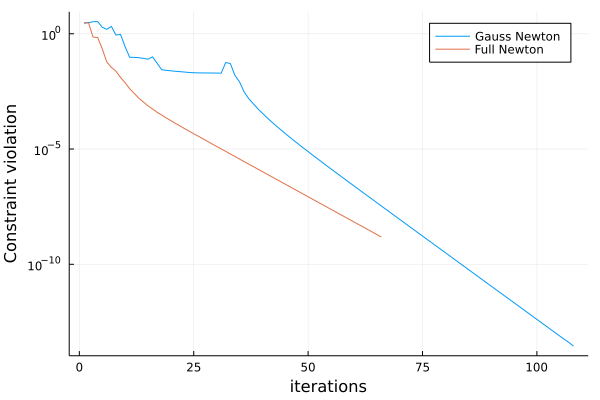

In [348]:
# TASK: Plot constraint violation vs iterations
plot(stats_gn[:viol_primal], label="Gauss Newton",
    yscale=:log10, xlabel="iterations", ylabel="Constraint violation", legend=:topright
)
plot!(stats_fn[:viol_primal], label="Full Newton")

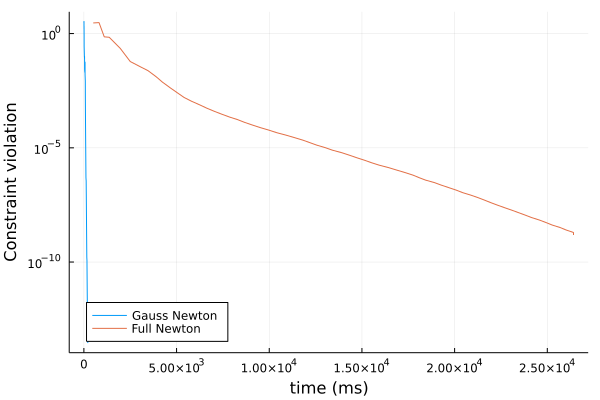

In [349]:
# TASK: Plot constraint violation vs time
plot(stats_gn[:time], stats_gn[:viol_primal], label="Gauss Newton",
    yscale=:log10, xlabel="time (ms)", ylabel="Constraint violation", legend=:bottomleft
)
plot!(stats_fn[:time], stats_fn[:viol_primal], label="Full Newton")

## Part (g): Track the solution with TVLQR
Let's now use our trajectory and simulate it on a system with some model mismatch.

**TASK**:
1. Generate a TVLQR controller that tracks your optimized trajectories.
2. Run your controller on a simulated cartpole with a cart mass of 1.1 kg instead of 1 kg. Get it to successfully stabilize. The final stabilized position doesn't have to to be at an x-position of 0. Simulate for at least 4 seconds.

**TIPS**:
1. Use code you've generated previously to build your TVLQR controller
2. If your cartpole gets it to the top but doesn't stabilize it for the full 4 seconds, think about how you could design your controller to stabilize it...

In [398]:
# TASK: Generate a TVLQR controller
#       Store your controller as the variable `ctrl`

# TODO: Replace this with a controller of your choice
ctrl = NullController(model)

# SOLUTION

function tvlqr(A,B,Q,R,Qf)
    # Extract some variables
    T = length(A)+1
    n,m = size(B[1])
    P = [zeros(n,n) for k = 1:T]
    K = [zeros(m,n) for k = 1:T-1]
    
    P[end] .= Qf
    for k = reverse(1:T-1) 
        K[k] .= (R + B[k]'P[k+1]*B[k])\(B[k]'P[k+1]*A[k])
        P[k] .= Q + A[k]'P[k+1]*A[k] - A[k]'P[k+1]*B[k]*K[k]
    end
    
    return K,P
end

function lqr(A,B,Q,R; max_iters=200, tol=1e-6)
    P = copy(Q)
    n,m = size(B)
    K = zeros(m,n)
    K_prev = copy(K)
    
    P = copy(Q)
    for k = 1:max_iters
        K .= (R + B'P*B) \ (B'P*A)
        P .= Q + A'P*A - A'P*B*K
#         println("iter $k =", norm(K-K_prev,Inf))
        if norm(K-K_prev,Inf) < tol
            println("Converged in $k iterations")
            return K
        end
        K_prev .= K
    end
    return K * NaN
end

"""
    LQRController

A TVLQR controller that tracks the trajectory specified by `Xref` and `Uref`
using the linear feedback gains `K`.
"""
struct LQRController
    K::Vector{Matrix{Float64}}
    Xref::Vector{Vector{Float64}}
    Uref::Vector{Vector{Float64}}
    times::Vector{Float64}
end
get_k(controller, t) = searchsortedlast(controller.times, t)

function get_control(ctrl::LQRController, x, t)
    k = get_k(ctrl, t)
    K = ctrl.K[k]
    return ctrl.Uref[k] - K*(x - ctrl.Xref[k])
end

# Generate A,B matrices
Xref,Uref = unpackZ(nlp, Zgn)
A = [zeros(n,n) for k = 1:T-1]
B = [zeros(n,m) for k = 1:T-1]
∇f = RobotDynamics.DynamicsJacobian(model)
for k = 1:T-1
    local t = nlp.times[k]
    local dt = nlp.times[k+1] - nlp.times[k]
    discrete_jacobian!(RK4, ∇f, model, Xref[k], Uref[k], t, dt)
    A[k] .= ∇f.A
    B[k] .= ∇f.B
end


Kinf = lqr(A[end], B[end], Matrix(Q), Matrix(R), max_iters=2000)

K, = tvlqr(A,B,Q,R,Qf)
push!(K, Kinf)
Uref[end] = [0]
# push!(Ufn,zeros(m))
ctrl = LQRController(K, Xref, Uref, nlp.times);

Converged in 1811 iterations


In [393]:
ctrl.Uref[end]

1-element Vector{Float64}:
 -2.089547298286001

In [390]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("rod" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x72, 0x6f, 0x64], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("cyl" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x63, 0x79, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "mass" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x6d, 0x61, 0x73, 0x73], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), "box" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x63, 0x61, 0x72, 0x74, 0x2f, 0x62, 0x6f, 0x78], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "hinge" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x72, 0x74, 0x2f, 0x68, 0x69, 0x6e, 0x67, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8714))

In [406]:
# Simulate with a different model
model2 = RobotZoo.Cartpole(1.1, 0.2, 0.5, 9.81)
Xsim, Usim, tsim = simulate(nlp.model, x0, ctrl, tf=5tf, dt=0.005)
visualize!(vis, model, tsim[end], Xsim)

Controller ran at 1.4873088183810855e6 Hz


## Tests

In [53]:
run_tests();

Test Summary: | Pass  Total
Q2            |   26     26
